The goal of this notebook is to construct a simple predictor of time-to-complete TTC for a particular link, based on the rate of change of files queued, for a set of queuing batches. This is accomplished by the following procedure:

1. Interpolate across nan values in 'queued-total', smooth the data
2. Locate maximums and minimums and segment regions that are decreasing
3. Fit line to each decreasing region
4. Measure TTC as the time interval from a particular max file queued to the intercept of the linear fit with the time axis
5. Repeat for all segments, and make a graph of 'Max # of files queued' vs. 'Time to complete'

The data is currently collected over a period of two weeks, binned hourly.

This notebook needs considerable work, especially in properly selecting the peak regions in the data.

In [1]:
#These lines set up inline plotting, and apply a standard size
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from elasticsearch import Elasticsearch, exceptions as es_exceptions
matplotlib.rc('font', **{'size': 15})

#Create instance of ElasticSearch using the Atlas host server
es = Elasticsearch(hosts=[{'host':'es-atlas.cern.ch', 'port':9202}],
                   http_auth=('es-atlas', 'v~$&<J8/cG9]*eQ@'),
                   timeout=60)

In [2]:
query = '''{
  "size": 0,
  "query": {
    "filtered": {
      "query": {
        "query_string": {
          "query": "src:%s AND dst:%s",
          "analyze_wildcard": True
        }
      },
      "filter": {
        "bool": {
          "must": [
            {
              "range": {
                "timestamp": {
                  "gte": %i,
                  "lte": %i,
                  "format": "epoch_millis"
                }
              }
            }
          ],
          "must_not": []
        }
      }
    }
  },
  "aggs": {
    "2": {
      "date_histogram": {
        "field": "timestamp",
        "interval": "1h",
        "time_zone": "Europe/Berlin",
        "min_doc_count": 1,
        "extended_bounds": {
          "min": %i,
          "max": %i
        }
      },
      "aggs": {
        "1": {
          "avg": {
            "field": "%s"
          }
        }
      }
    }
  }
}'''

In [3]:
import ast
import time

tic = time.time()

currentMilliTime = int(round(time.time()*1000))
milliWeek = 7*24*60*60*1000
milliTwoWeek = 2*7*24*60*60*1000
milliMonth = 30*24*60*60*1000
milliDay = 24*60*60*1000
milliHour = 60*60*1000

start = currentMilliTime - milliTwoWeek
end = currentMilliTime

index=0
#src = 'AGLT2'
#src = 'SARA-MATRIX'

src = 'SARA-MATRIX'
dst = 'BNL-ATLAS'

queuedQuery = ast.literal_eval(query%(src,dst,start,end,start,end,'queued-total'))    

queuedResponse = es.search(index="atlas_ddm-metrics*", body=queuedQuery, request_timeout=600) 

queuedData = []
timestamp = []

for r in queuedResponse['aggregations']['2']['buckets']:
    queuedData.append(r['1']['value'])
    timestamp.append(r['key'])    

#Replace None values with NaNs
queuedData = np.array(queuedData,dtype=np.float)
timestamp = np.array(timestamp,dtype=np.float)

toc = time.time()

print('This aggregation and fetching took %f seconds'%(toc-tic))

This aggregation and fetching took 1.364089 seconds


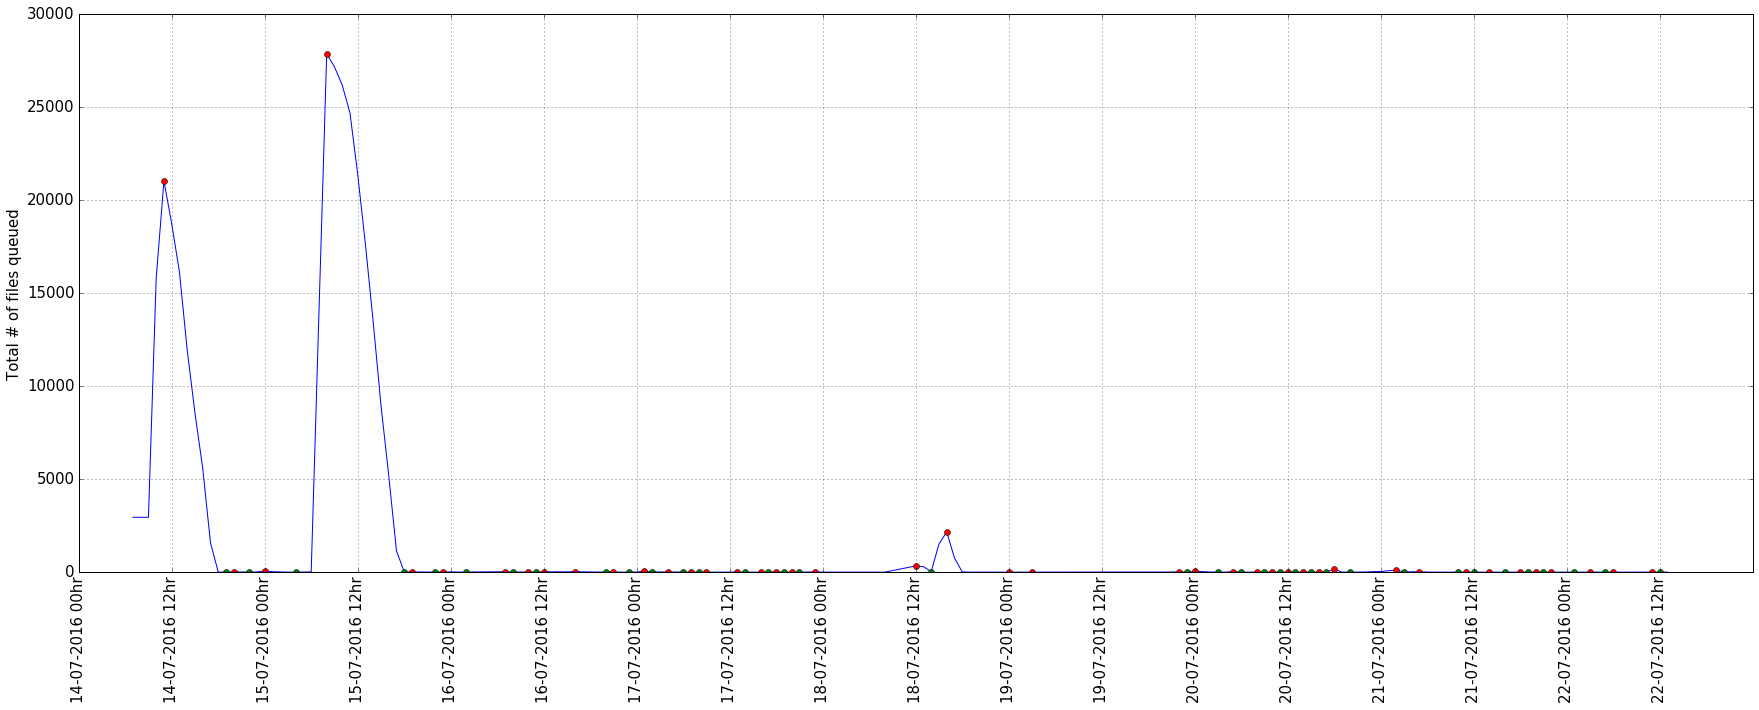

In [4]:
import matplotlib.dates as dt
from scipy.signal import savgol_filter,argrelmin,argrelmax
from scipy.ndimage.filters import median_filter,gaussian_filter

#Interpolate missing values in data
indices = np.logical_not(np.isnan(queuedData))
timestampNan = timestamp[indices]
queuedNan = queuedData[indices]
queuedInterp = np.interp(timestamp,timestampNan,queuedNan)


#Find max values, which we assume corresponds to the total # of files queued for that task.
maxQueued = argrelmax(queuedInterp)[0]
#Find local min values of data, from which we hope to get a linear slope
minQueued = argrelmin(queuedInterp)[0]

dateTime = dt.epoch2num(timestamp/1000.)

plt.figure(figsize=(30,10))
plt.plot(dateTime,queuedInterp,'b-')
plt.plot(dateTime[maxQueued],queuedInterp[maxQueued],'ro')
plt.plot(dateTime[minQueued],queuedInterp[minQueued],'go')

ax = plt.gca()
#Tedious date/time formatting
xfmt = dt.DateFormatter('%d-%m-%Y %Hhr')
ax.xaxis.set_major_formatter(xfmt)
ax.xaxis_date()
start, end = ax.get_xlim()

plt.xticks(np.arange(start, end,1/2),rotation= 90 )
plt.ylabel('Total # of files queued')
plt.title('')
plt.grid()

The code below finds the peaks 

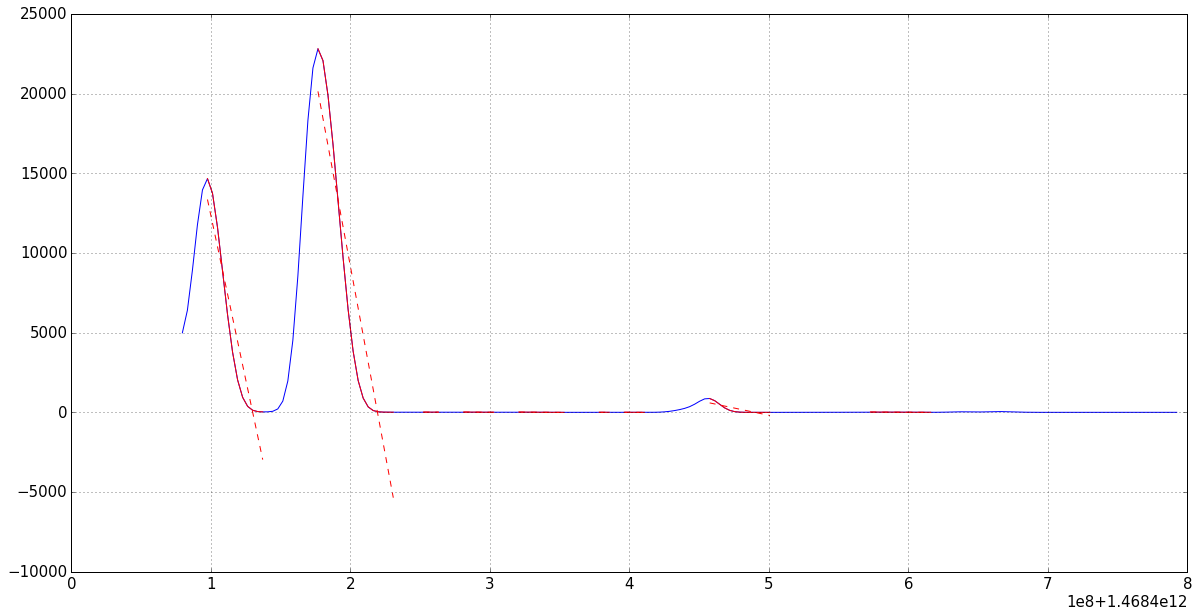

In [5]:
#Find mins and maxs in data, to determine "queuing events"
queuedSmoothed = gaussian_filter(queuedInterp,2)
#Find max values, which we assume corresponds to the total # of files queued for that task.
maxQueued = argrelmax(queuedSmoothed)[0]

#Find local min values of data, from which we hope to get a linear slope
minQueued = argrelmin(queuedSmoothed)[0]

ttcVals = []
queueMaxVals = []

#Initialize queued segment, corresponding timestamp segment, and polynomial coefficients
q = []
t = []
p = []
for i in range(len(maxQueued)-5):
    maximum = maxQueued[i]
    #Get first min value whose index is greater than the max
    minimum = minQueued[(minQueued > maximum)][0]

    #Get data in range
    q.append(queuedSmoothed[maximum:(minimum+1)])
    t.append(timestamp[maximum:(minimum+1)])
    
    #Trying to weight the polynomial so that it passes through the max and min of each segment
    
    #Fit data to polynomial
    p.append(np.polyfit(t[i], q[i], 1))
    
    ttc = (np.roots(p[i])[0] - timestamp[maximum])/(1000*60*60)
    ttcVals.append(ttc)
    queueMaxVals.append(queuedSmoothed[maximum])


plt.figure(figsize=(20,10))
plt.plot(timestamp,queuedSmoothed)

ind = 0
for i in range(len(t)):
    #Plot fitted polynomial
    plt.plot(t[ind],np.polyval(p[ind],t[ind]),'r--')  
    plt.plot(t[ind],q[ind],'r')
    ind += 1

plt.grid()


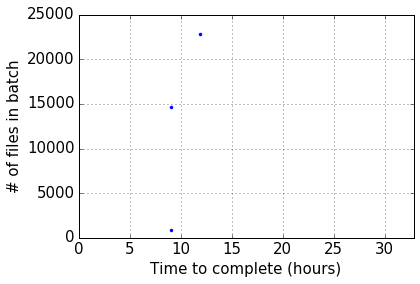

In [6]:
queueMaxVals = np.array(queueMaxVals) 
ttcVals = np.array(ttcVals)

#Ignore events that have a max queue value less than 50
indices = queueMaxVals>=50

plt.plot(ttcVals[indices], queueMaxVals[indices],'b.')
ax = plt.gca()
ax.set_yscale('linear')
plt.xlim(0,np.max(ttcVals))
plt.ylabel('# of files in batch')
plt.xlabel('Time to complete (hours)')
plt.grid()

In [7]:
p = np.polyfit(ttcVals[indices], queueMaxVals[indices], 1)
np.roots(p)

array([ 7.53268924])

In [8]:
queueMaxVals

array([  1.46633851e+04,   2.28075834e+04,   1.55562471e+01,
         1.85462878e+01,   1.81750591e+01,   6.25290578e+00,
         6.37045918e+00,   8.69419058e+02,   2.06878392e+01])

In [9]:
ttcVals

array([  9.00177679,  11.84991311,  32.81037317,   9.03187599,
         8.79059214,  25.99787082,   5.65243987,   9.01073078,  13.72607605])